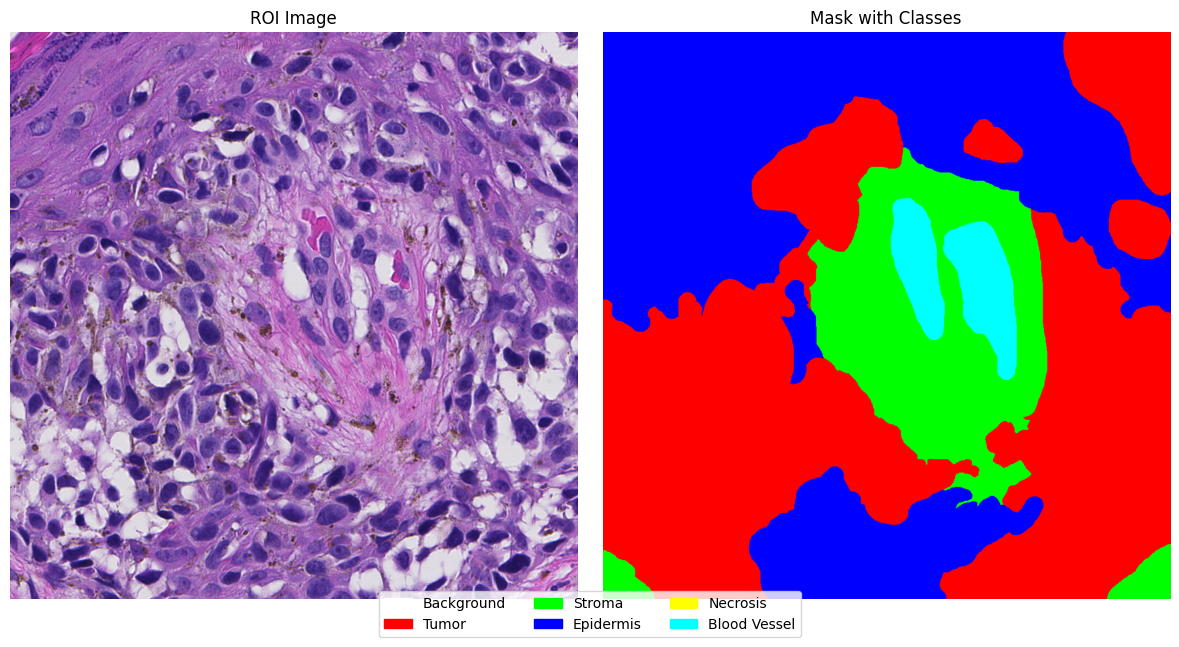

In [12]:
import os
import json
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 类别映射
class_mapping = {
    "tissue_tumor": 1,
    "tissue_stroma": 2,
    "tissue_epidermis": 3,
    "tissue_necrosis": 4,
    "tissue_blood_vessel": 5,
    "tissue_white_background": 0
}

# 颜色映射（颜色值可以根据需要调整）
color_mapping = {
    0: (1.0, 1.0, 1.0),  # 白色 - 背景
    1: (1.0, 0.0, 0.0),  # 红色 - 肿瘤
    2: (0.0, 1.0, 0.0),  # 绿色 - 基质
    3: (0.0, 0.0, 1.0),  # 蓝色 - 表皮
    4: (1.0, 1.0, 0.0),  # 黄色 - 坏死
    5: (0.0, 1.0, 1.0)   # 青色 - 血管
}

class_labels = {
    0: "Background",
    1: "Tumor",
    2: "Stroma",
    3: "Epidermis",
    4: "Necrosis",
    5: "Blood Vessel"
}

def process_single_pair(roi_path, tissue_path, class_mapping, image_size=(1024, 1024)):
    """
    处理单对 ROI 图像和标注文件，生成可视化的 mask。
    Args:
        roi_path (str): ROI 图像文件路径
        tissue_path (str): 标注文件路径
        class_mapping (dict): 类别映射
        image_size (tuple): 输出 mask 的大小
    Returns:
        tuple: 原始图像、生成的 mask
    """
    # 加载 ROI 图像
    with rasterio.open(roi_path) as src:
        roi_image = src.read([1, 2, 3]) / 255.0
        roi_image = roi_image.transpose(1, 2, 0)

    # 加载 tissue mask
    tissue_gdf = gpd.read_file(tissue_path)
    shapes_list = []
    for _, row in tissue_gdf.iterrows():
        if row.geometry.geom_type not in ["Polygon", "MultiPolygon"]:
            continue

        classification = row["classification"]
        if isinstance(classification, str):
            classification = json.loads(classification)

        class_name = classification.get("name", "tissue_white_background")
        label = class_mapping.get(class_name, 0)
        shapes_list.append((row.geometry, label))

    transform = rasterio.transform.Affine(1, 0, 0, 0, 1, 0)
    mask = rasterize(
        shapes_list,
        out_shape=image_size,
        fill=0,
        transform=transform,
        dtype=np.uint8,
        default_value=0,
    )

    return roi_image, mask

# 输入文件路径
roi_path = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTs/training_set_primary_roi_103_0000.tif"
tissue_path = "/root/autodl-fs/training_set_primary_roi_103_tissue.geojson"

# 处理文件
image, mask = process_single_pair(roi_path, tissue_path, class_mapping)

# 创建颜色映射矩阵
colored_mask = np.zeros((*mask.shape, 3))
for class_id, color in color_mapping.items():
    colored_mask[mask == class_id] = color

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title('ROI Image')
axes[0].axis('off')

axes[1].imshow(colored_mask)
axes[1].set_title('Mask with Classes')
axes[1].axis('off')

# 添加图例
legend_patches = [Patch(color=color_mapping[class_id], label=class_labels[class_id])
                  for class_id in color_mapping]
fig.legend(handles=legend_patches, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()

# examing the distribution of the dataset

In [ ]:
import os
import json
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.features import rasterize
from torch.utils.data import Dataset
from collections import Counter

class_mapping = {
    "tissue_tumor": 1,
    "tissue_stroma": 2,
    "tissue_epidermis": 3,
    "tissue_necrosis": 4,
    "tissue_blood_vessel": 5,
    "tissue_white_background": 0
}

# 与之前相同的数据集定义
class SegmentationDataset(Dataset):
    def __init__(self, roi_files, tissue_files, roi_dir, tissue_dir, class_mapping, image_size=(1024, 1024)):
        self.roi_files = roi_files
        self.tissue_files = tissue_files
        self.roi_dir = roi_dir
        self.tissue_dir = tissue_dir
        self.class_mapping = class_mapping
        self.image_size = image_size

    def __len__(self):
        return len(self.roi_files)

    def __getitem__(self, idx):
        roi_path = os.path.join(self.roi_dir, self.roi_files[idx])
        tissue_path = os.path.join(self.tissue_dir, self.tissue_files[idx])

        # 读取图像大小信息
        with rasterio.open(roi_path) as src:
            _, height, width = src.read([1, 2, 3]).shape

        # 构建 shapes_list
        tissue_gdf = gpd.read_file(tissue_path)
        shapes_list = []
        for _, row in tissue_gdf.iterrows():
            if row.geometry.geom_type not in ["Polygon", "MultiPolygon"]:
                continue
            classification = row["classification"]
            if isinstance(classification, str):
                classification = json.loads(classification)
            class_name = classification.get("name", "tissue_white_background")
            label = self.class_mapping.get(class_name, 0)
            shapes_list.append((row.geometry, label))

        transform = rasterio.transform.Affine(1, 0, 0, 0, 1, 0)
        mask = rasterize(
            shapes_list,
            out_shape=self.image_size,
            fill=0,
            transform=transform,
            dtype=np.uint8,
            default_value=0,
        )

        return mask

# 假设数据路径与之前相同
roi_dir = "/content/drive/MyDrive/mldl/FinalProject/dataset/01_training_dataset_tif_ROIs"
tissue_dir = "/content/drive/MyDrive/mldl/FinalProject/dataset/01_training_dataset_geojson_tissue"
roi_files = [f for f in os.listdir(roi_dir) if f.endswith(".tif")]
tissue_files = [f.replace(".tif", "_tissue.geojson") for f in roi_files]

dataset = SegmentationDataset(roi_files, tissue_files, roi_dir, tissue_dir, class_mapping)

# 统计所有类的像素数量
class_pixel_count = Counter()

for i in range(len(dataset)):
    mask = dataset[i]
    unique, counts = np.unique(mask, return_counts=True)
    for u, c in zip(unique, counts):
        class_pixel_count[u] += c

# 输出统计结果
total_pixels = sum(class_pixel_count.values())
print("类像素统计：")
for cls_id in sorted(class_pixel_count.keys()):
    count = class_pixel_count[cls_id]
    ratio = count / total_pixels * 100
    print(f"Class {cls_id}: {count} pixels ({ratio:.2f}%)")

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/usr/local/l

类像素统计：
Class 0: 651116 pixels (0.30%)
Class 1: 149738044 pixels (69.66%)
Class 2: 53953554 pixels (25.10%)
Class 3: 5078899 pixels (2.36%)
Class 4: 2348178 pixels (1.09%)
Class 5: 3188289 pixels (1.48%)


In [ ]:
import numpy as np
import geopandas as gpd
import json
from pathlib import Path

class_mapping = {
    "tissue_tumor": 1,
    "tissue_stroma": 2,
    "tissue_epidermis": 3,
    "tissue_necrosis": 4,
    "tissue_blood_vessel": 5,
    "tissue_white_background": 0
}

# 你的输入和输出路径（请根据需要修改）
geojson_folder = Path("/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_geojson_tissue")
image_size = (1024, 1024)
h, w = image_size

# 用于统计的字典
summary = {
    "total_files": 0,
    "files_with_no_geometry": 0,
    "total_annotations": 0,
    "unmapped_classifications": {},
    "invalid_polygons": 0,
    "valid_polygons": 0,
}

geojson_files = list(geojson_folder.glob("*.geojson"))

for geojson_path in geojson_files:
    gdf = gpd.read_file(geojson_path)
    summary["total_files"] += 1

    if gdf.empty:
        summary["files_with_no_geometry"] += 1
        print(f"File: {geojson_path.name} - No geometries found.")
        continue

    print(f"\n=== Analyzing {geojson_path.name} ===")
    print(f"Total annotations: {len(gdf)}")
    summary["total_annotations"] += len(gdf)

    for idx, row in gdf.iterrows():
        classification = row.get("classification", {})
        if isinstance(classification, str):
            classification = json.loads(classification)

        label_name = classification.get("name", "unknown_class")
        label = class_mapping.get(label_name, 0)

        # 打印分类映射结果
        if label == 0:
            print(f"  Annotation {idx}: Unmapped classification '{label_name}'")
            summary["unmapped_classifications"][label_name] = summary["unmapped_classifications"].get(label_name, 0) + 1
        else:
            print(f"  Annotation {idx}: '{label_name}' -> label {label}")

        if row.geometry is None:
            print(f"    No geometry for this annotation.")
            continue

        geom_type = row.geometry.geom_type
        # 提取多边形坐标列表
        if geom_type == "Polygon":
            polygons = [np.array(row.geometry.exterior.coords)]
        elif geom_type == "MultiPolygon":
            polygons = [np.array(p.exterior.coords) for p in row.geometry.geoms]
        else:
            print(f"    Unsupported geometry type: {geom_type}")
            continue

        for p_idx, polygon in enumerate(polygons):
            # 原始坐标信息
            min_x, min_y = polygon.min(axis=0)
            max_x, max_y = polygon.max(axis=0)
            print(f"    Polygon {p_idx} original coords range: x[{min_x}, {max_x}], y[{min_y}, {max_y}]")

            polygon_int = np.round(polygon).astype(np.int32)
            polygon_clipped = np.clip(polygon_int, [0, 0], [w-1, h-1])
            c_min_x, c_min_y = polygon_clipped.min(axis=0)
            c_max_x, c_max_y = polygon_clipped.max(axis=0)

            print(f"    Polygon {p_idx} clipped coords range: x[{c_min_x}, {c_max_x}], y[{c_min_y}, {c_max_y}]")
            print(f"    Polygon {p_idx} number of points: {len(polygon_clipped)}")

            if len(polygon_clipped) < 3:
                print("    Invalid polygon (less than 3 points after clipping)")
                summary["invalid_polygons"] += 1
            else:
                summary["valid_polygons"] += 1

print("\n=== Summary Report ===")
print(f"Total files: {summary['total_files']}")
print(f"Files with no geometry: {summary['files_with_no_geometry']}")
print(f"Total annotations: {summary['total_annotations']}")
print(f"Invalid polygons (less than 3 points): {summary['invalid_polygons']}")
print(f"Valid polygons: {summary['valid_polygons']}")

if summary["unmapped_classifications"]:
    print("Unmapped classifications and their counts:")
    for cls_name, count in summary["unmapped_classifications"].items():
        print(f"  {cls_name}: {count}")
else:
    print("No unmapped classifications found.")


In [43]:
import json
from pathlib import Path
import geopandas as gpd

def extract_classes_from_geojson(folder_path):
    """
    Extract unique class names from all GeoJSON files in a folder.

    Args:
        folder_path (str): Path to the folder containing GeoJSON files.

    Returns:
        set: A set of unique class names found in the GeoJSON files.
    """
    folder = Path(folder_path)
    if not folder.exists():
        raise ValueError(f"The folder {folder_path} does not exist.")

    geojson_files = list(folder.glob("*.geojson"))
    if not geojson_files:
        print(f"No GeoJSON files found in {folder_path}")
        return set()

    all_classes = set()

    for geojson_file in geojson_files:
        try:
            gdf = gpd.read_file(geojson_file)
            for _, row in gdf.iterrows():
                classification = row.get("classification", {})
                if isinstance(classification, str):
                    classification = json.loads(classification)  # Parse string to JSON
                class_name = classification.get("name", "unknown_class")
                all_classes.add(class_name)
        except Exception as e:
            print(f"Error processing {geojson_file}: {e}")
    
    return all_classes

# Specify the input folder containing GeoJSON files
geojson_folder = "/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_geojson_tissue"  # Replace with your folder path

# Extract all classes
unique_classes = extract_classes_from_geojson(geojson_folder)

# Print the results
print("Unique classes found in GeoJSON files:")
for class_name in sorted(unique_classes):
    print(class_name)

Unique classes found in GeoJSON files:
tissue_blood_vessel
tissue_epidermis
tissue_necrosis
tissue_stroma
tissue_tumor
tissue_white_background


# nnUnet

In [ ]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git
!cd nnUNet
!pip install -e .

fatal: destination path 'nnUNet' already exists and is not an empty directory.
Obtaining file:///content
ERROR: file:///content does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## transform geojson file to json 

In [ ]:
import json
from pathlib import Path
import geopandas as gpd

def convert_geojson_to_json(geojson_file, output_folder):
    """
    Converts a GeoJSON file to a simplified JSON file.

    Args:
        geojson_file (Path): Path to the GeoJSON file.
        output_folder (Path): Path to save the converted JSON file.
    """
    # Read the GeoJSON file
    gdf = gpd.read_file(geojson_file)
    
    # Prepare simplified JSON structure
    features = []
    for _, row in gdf.iterrows():
        # Extract geometry and properties
        geometry = row.geometry.__geo_interface__ if row.geometry else None
        properties = row.to_dict()
        properties.pop("geometry", None)  # Remove geometry from properties to avoid duplication
        
        features.append({
            "geometry": geometry,
            "properties": properties
        })
    
    # Construct the simplified JSON
    simplified_json = {
        "type": "FeatureCollection",
        "features": features
    }
    
    # Define output file path
    output_file = output_folder / f"{geojson_file.stem}.json"
    
    # Save the simplified JSON to the output file
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(simplified_json, f, indent=4, ensure_ascii=False)
    
    print(f"Converted {geojson_file} to {output_file}")

# Define input and output directories
geojson_folder = Path("/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_geojson_tissue")
output_folder = Path("/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_json_tissue")

# Ensure output folder exists
output_folder.mkdir(exist_ok=True)

# Process all GeoJSON files in the input folder
geojson_files = list(geojson_folder.glob("*.geojson"))
if not geojson_files:
    print("No GeoJSON files found in the input folder.")
else:
    for geojson_file in geojson_files:
        try:
            convert_geojson_to_json(geojson_file, output_folder)
        except Exception as e:
            print(f"Error processing {geojson_file}: {e}")

print(f"Processed {len(geojson_files)} GeoJSON files. Converted files saved to: {output_folder}")

## generate the mask file from geojson

In [69]:
import numpy as np
import geopandas as gpd
import cv2
import json
from pathlib import Path

class_mapping = {
    "tissue_tumor": 1,
    "tissue_stroma": 2,
    "tissue_epidermis": 3,
    "tissue_necrosis": 4,
    "tissue_blood_vessel": 5,
    "tissue_white_background": 0
}

def geojson_to_mask(geojson_path, mask_path, image_size=(1024, 1024)):
    """
    Converts a GeoJSON file to a mask image and saves it.

    Args:
        geojson_path (Path): Path to the GeoJSON file.
        mask_path (Path): Path to save the mask image.
        image_size (tuple): Size of the output mask (height, width).
    """
    h, w = image_size
    mask = np.zeros((h, w), dtype=np.uint8)  # Initialize an empty mask
    gdf = gpd.read_file(geojson_path)

    if not gdf.empty:
        for _, row in gdf.iterrows():
            if row.geometry is None:
                print(f"No geometry in row: {row}")
                continue

            classification = row.get("classification", {})
            if isinstance(classification, str):
                try:
                    classification = json.loads(classification)
                except json.JSONDecodeError:
                    print(f"Failed to parse classification: {classification}")
                    continue

            label_name = classification.get("name", "unknown_class")
            if label_name not in class_mapping:
                print(f"Unmapped label: {label_name}")
                continue

            label = class_mapping[label_name]
            if label == 0:  # Skip background
                continue

            if row.geometry.geom_type == "Polygon":
                polygons = [np.array(row.geometry.exterior.coords)]
            elif row.geometry.geom_type == "MultiPolygon":
                polygons = [np.array(p.exterior.coords) for p in row.geometry.geoms]
            else:
                print(f"Unsupported geometry type: {row.geometry.geom_type}")
                continue

            for polygon in polygons:
                polygon = np.round(polygon).astype(np.int32)
                polygon = np.clip(polygon, [0, 0], [w-1, h-1])  # Clip to valid image bounds

                if len(polygon) < 3:
                    continue

                # Fill the polygon in the mask
                cv2.fillPoly(mask, [polygon], int(label))

        # Save the raw mask
        cv2.imwrite(str(mask_path), mask)
        print(f"Unique values in mask: {np.unique(mask)}")

# File paths
geojson_folder = Path("/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_geojson_tissue")
mask_folder = Path("/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/labelsTr")
mask_folder.mkdir(exist_ok=True, parents=True)

geojson_files = list(geojson_folder.glob("*.geojson"))
for geojson_path in geojson_files:
    mask_name = f"{geojson_path.stem}.tif"
    mask_path = mask_folder / mask_name
    try:
        geojson_to_mask(geojson_path, mask_path)
    except Exception as e:
        print(f"Error processing {geojson_path}: {e}")

print(f"Processed {len(geojson_files)} GeoJSON files. Masks saved to: {mask_folder}")

Unique values in mask: [1 4]
Unique values in mask: [1 2 5]
Unique values in mask: [1 2]
Unique values in mask: [1]
Unique values in mask: [1 2 5]
Unique values in mask: [1 2]
Unique values in mask: [1 2]
Unique values in mask: [0 4]
Unique values in mask: [1]
Unique values in mask: [1 2]
Unique values in mask: [1]
Unique values in mask: [1]
Unique values in mask: [1]
Unique values in mask: [1 2]
Unique values in mask: [1]
Unique values in mask: [0 1 2]
Unique values in mask: [1]
Unique values in mask: [1 2]
Unique values in mask: [1 2]
Unique values in mask: [1 2]
Unique values in mask: [0 1]
Unique values in mask: [1 5]
Unique values in mask: [1]
Unique values in mask: [1 4]
Unique values in mask: [1 2]
Unique values in mask: [1 2]
Unique values in mask: [1 2]
Unique values in mask: [1]
Unique values in mask: [0 1]
Unique values in mask: [1]
Unique values in mask: [1]
Unique values in mask: [1 2 5]
Unique values in mask: [1]
Unique values in mask: [1]
Unique values in mask: [1]
Uniqu

## rename the file to delete __tissue

In [70]:
import os

def rename_files(folder_path):
    """
    Remove '_tissue' from all file names in the given folder.
    
    Args:
        folder_path (str): Path to the folder containing files to rename.
    """
    for file_name in os.listdir(folder_path):
        # Check if '_tissue' exists in the file name
        if '_tissue' in file_name:
            # Construct the new file name
            new_file_name = file_name.replace('_tissue', '')
            # Get full paths
            old_file_path = os.path.join(folder_path, file_name)
            new_file_path = os.path.join(folder_path, new_file_name)
            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {file_name} -> {new_file_name}")

# Specify the folder containing the files
folder_path = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/labelsTr"

# Call the function
rename_files(folder_path)

print("All files renamed successfully!")

Renamed: training_set_metastatic_roi_001_tissue.tif -> training_set_metastatic_roi_001.tif
Renamed: training_set_metastatic_roi_002_tissue.tif -> training_set_metastatic_roi_002.tif
Renamed: training_set_metastatic_roi_003_tissue.tif -> training_set_metastatic_roi_003.tif
Renamed: training_set_metastatic_roi_004_tissue.tif -> training_set_metastatic_roi_004.tif
Renamed: training_set_metastatic_roi_005_tissue.tif -> training_set_metastatic_roi_005.tif
Renamed: training_set_metastatic_roi_006_tissue.tif -> training_set_metastatic_roi_006.tif
Renamed: training_set_metastatic_roi_007_tissue.tif -> training_set_metastatic_roi_007.tif
Renamed: training_set_metastatic_roi_008_tissue.tif -> training_set_metastatic_roi_008.tif
Renamed: training_set_metastatic_roi_009_tissue.tif -> training_set_metastatic_roi_009.tif
Renamed: training_set_metastatic_roi_010_tissue.tif -> training_set_metastatic_roi_010.tif
Renamed: training_set_metastatic_roi_011_tissue.tif -> training_set_metastatic_roi_011.tif

In [ ]:
# import os
# import fiona
# import rasterio
# import rasterio.mask
# import numpy as np

# def generate_mask(geojson_path, tiff_path, output_folder):
#     """
#     Generate binary masks from GeoJSON and corresponding TIFF files.

#     Args:
#         geojson_path (str): Path to the GeoJSON file.
#         tiff_path (str): Path to the TIFF file.
#         output_folder (str): Folder to save the generated mask.

#     Returns:
#         None
#     """
#     # Ensure output folder exists
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     # Open GeoJSON and extract geometries
#     with fiona.open(geojson_path, "r") as geojson:
#         features = []
#         for feature in geojson:
#             geometry = feature["geometry"]
#             # Ensure coordinates are integers and within valid bounds
#             if geometry["type"] == "Polygon":
#                 polygons = [
#                     [(int(coord[0]), int(coord[1])) for coord in ring]
#                     for ring in geometry["coordinates"]
#                 ]
#                 features.append({"type": "Polygon", "coordinates": polygons})
#             elif geometry["type"] == "MultiPolygon":
#                 for polygon in geometry["coordinates"]:
#                     polygons = [
#                         [(int(coord[0]), int(coord[1])) for coord in ring]
#                         for ring in polygon
#                     ]
#                     features.append({"type": "Polygon", "coordinates": polygons})

#     # Open TIFF and apply mask
#     with rasterio.open(tiff_path) as src:
#         # Debug: Check TIFF metadata and bounds
#         print(f"Processing {tiff_path}")
#         print("TIFF bounds:", src.bounds)
#         print("TIFF transform:", src.transform)

#         try:
#             out_image, out_transform = rasterio.mask.mask(src, features, crop=True)
#             out_meta = src.meta
#         except ValueError as e:
#             print(f"Error during mask creation: {e}")
#             return

#     # Debug: Print unique values in the masked image
#     print("Unique values in masked image:", np.unique(out_image))

#     # Convert mask to binary
#     binary_mask = (out_image[0] > 0).astype(np.uint8)

#     # Debug: Print unique values in binary mask
#     print("Unique values in binary mask:", np.unique(binary_mask))

#     # Update metadata for saving
#     out_meta.update({
#         "driver": "GTiff",
#         "height": binary_mask.shape[0],
#         "width": binary_mask.shape[1],
#         "count": 1,
#         "dtype": "uint8",
#         "transform": out_transform  # Update transform if cropped
#     })

#     # Save binary mask
#     output_path = os.path.join(output_folder, os.path.basename(geojson_path).replace(".geojson", "_mask.tif"))
#     with rasterio.open(output_path, "w", **out_meta) as dst:
#         dst.write(binary_mask, 1)
#     print(f"Mask saved to: {output_path}")

# # Define input and output folders
# geojson_folder = "/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_geojson_tissue"  # Replace with your GeoJSON folder
# tiff_folder = "/root/autodl-tmp/PUMA-challenge-baseline-track1/dataset/01_training_dataset_tif_ROIs"        # Replace with your TIFF folder
# output_folder = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/labelsTr"    # Replace with your desired output folder

# # Process all GeoJSON and TIFF files in the folders
# geojson_files = sorted([f for f in os.listdir(geojson_folder) if f.endswith(".geojson")])
# tiff_files = sorted([f for f in os.listdir(tiff_folder) if f.endswith(".tif")])

# for geojson_file, tiff_file in zip(geojson_files, tiff_files):
#     geojson_path = os.path.join(geojson_folder, geojson_file)
#     tiff_path = os.path.join(tiff_folder, tiff_file)
#     try:
#         generate_mask(geojson_path, tiff_path, output_folder)
#     except Exception as e:
#         print(f"Error processing {geojson_file} and {tiff_file}: {e}")

In [79]:
#generate the datajson
import os
import json

def generate_dataset_json(dataset_dir, output_file, task_name, labels):
    imagesTr_dir = os.path.join(dataset_dir, "imagesTr")
    labelsTr_dir = os.path.join(dataset_dir, "labelsTr")
    imagesTs_dir = os.path.join(dataset_dir, "imagesTs")

    # 获取训练和测试文件列表
    training_images = sorted([f for f in os.listdir(imagesTr_dir) if f.endswith(".nii.gz")])
    training_labels = sorted([f for f in os.listdir(labelsTr_dir) if f.endswith(".nii.gz")])
    test_images = sorted([f for f in os.listdir(imagesTs_dir) if f.endswith(".nii.gz")])

    # 验证文件匹配
    # 图像文件：tissue_001_0000.nii.gz
    # 标签文件：tissue_001.nii.gz
    # 将图像文件名中的_0000去除后再比较
    assert len(training_images) == len(training_labels), "训练图像和标签文件数量不匹配！"
    for img, lbl in zip(training_images, training_labels):
        img_base = img.replace(".nii.gz", "").replace("_0000", "")
        lbl_base = lbl.replace(".nii.gz", "")
        assert img_base == lbl_base, f"文件名不匹配: {img} 和 {lbl}"

    # 创建 JSON 数据结构
    dataset_json = {
        "name": task_name,
        "description": f"{task_name} for nnUNet",
        "tensorImageSize": "3D",
        "reference": "Provide reference if applicable",
        "licence": "Provide licence info",
        "release": "1.0",
        "modality": {
            "0": "RGB"  # 单通道：0
        },
        "labels": labels,
        "numTraining": len(training_images),
        "numTest": len(test_images),
        "channel_names": {
            "0": "RGB"
        },
        "file_ending": ".nii.gz",
        "training": [
            {
                "image": f"./imagesTr/{img}",
                "label": f"./labelsTr/{lbl}"
            }
            for img, lbl in zip(training_images, training_labels)
        ],
        "test": [
            f"./imagesTs/{img}" for img in test_images
        ]
    }

    # 保存到文件
    with open(output_file, "w") as f:
        json.dump(dataset_json, f, indent=4)
    print(f"`dataset.json` 已保存到 {output_file}")

# 使用示例
dataset_dir = "/content/drive/MyDrive/mldl/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA"
output_file = os.path.join(dataset_dir, "dataset.json")
task_name = "PUMA Dataset"
labels = {
            "background": 0,
            "tissue_tumor": 1,
            "tissue_stroma": 2,
            "tissue_epidermis": 3,
            "tissue_necrosis": 4,
            "tissue_blood_vessel": 5
}

generate_dataset_json(dataset_dir, output_file, task_name, labels)

`dataset.json` 已保存到 /content/drive/MyDrive/mldl/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/dataset.json


## set environment parameters


In [1]:
import os

# 设置环境变量
os.environ["nnUNet_raw"] = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results"

# 检查是否设置成功
print("nnUNet_raw:", os.environ.get("nnUNet_raw"))
print("nnUNet_preprocessed:", os.environ.get("nnUNet_preprocessed"))
print("nnUNet_results:", os.environ.get("nnUNet_results"))


nnUNet_raw: /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw
nnUNet_preprocessed: /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_preprocessed
nnUNet_results: /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results


## dataset preprocessing

In [ ]:
import os

# 定义文件夹路径
images_dir = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTr"
labels_dir = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/labelsTr"

# 获取文件列表
images_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".tif")])
labels_files = sorted([f for f in os.listdir(labels_dir) if f.endswith(".tif")])

# 检查文件数量
print(f"Images: {len(images_files)}, Labels: {len(labels_files)}")

# 检查文件名是否匹配
for img, lbl in zip(images_files, labels_files):
    if img.replace("_0000.nii.gz", "") != lbl.replace(".nii.gz", ""):
        print(f"Mismatch: {img} vs {lbl}")

## rename the imagesTr

In [18]:
import os

# 获取当前工作目录
current_folder = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTs"



# 遍历当前目录下的所有文件
for filename in os.listdir(current_folder):
    # 检查是否为 .tif 文件
    if filename.endswith('.tif'):
        print(f"Processing file: {filename}")

        # 如果文件名以 "_0000" 开头，去掉它
        if filename.startswith('_0000'):
            filename = filename[5:]  # 去掉前 5 个字符

        # 构造新的文件名，在 .tif 前添加 "_0000"
        new_filename = filename.replace('.tif', '_0000.tif')

        # 获取原始文件路径和新文件路径
        old_path = os.path.join(current_folder, filename)
        new_path = os.path.join(current_folder, new_filename)

        # 检查文件是否存在，防止找不到文件报错
        if not os.path.exists(old_path):
            print(f"File not found: {old_path}")
            continue

        # 重命名文件
        os.rename(old_path, new_path)
        print(f"Renamed: {old_path} -> {new_path}")

print("Renaming completed.")

Processing file: training_set_primary_roi_102.tif
Renamed: /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/imagesTs/training_set_primary_roi_102.tif -> /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/imagesTs/training_set_primary_roi_102_0000.tif
Processing file: training_set_primary_roi_103.tif
Renamed: /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/imagesTs/training_set_primary_roi_103.tif -> /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/imagesTs/training_set_primary_roi_103_0000.tif
Renaming completed.


In [ ]:
import os

# 定义目标文件夹路径
folder_path = r'/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTr'  # 替换为你的文件夹路径

# 遍历文件夹中的所有文件
for file_name in os.listdir(folder_path):
    # 检查是否是以 _0000.tif 结尾的文件
    if file_name.endswith('_0000.tif'):
        # 分离文件名和扩展名
        name_part, ext = os.path.splitext(file_name)

        # 检查中间是否包含 _0000
        # 确保只移除最后一个 _0000 前的其他 _0000
        if '_0000' in name_part:
            new_name_part = name_part.replace('_0000', '')  # 移除中间的 _0000
            new_file_name = f"{new_name_part}_0000{ext}"  # 保持结尾的 _0000.tif 不变

            # 获取完整路径
            old_path = os.path.join(folder_path, file_name)
            new_path = os.path.join(folder_path, new_file_name)

            # 重命名文件
            os.rename(old_path, new_path)
            print(f"Renamed: {file_name} -> {new_file_name}")

print("All applicable files have been renamed successfully!")

In [27]:
from PIL import Image

file_path = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/imagesTr/training_set_metastatic_roi_050_0000.tif"
image = Image.open(file_path)
print("Image size:", image.size)
print("Image mode:", image.mode)

Image size: (1024, 1024)
Image mode: RGBA


In [ ]:
import os
import shutil

def copy_files(src_folder, dest_folder):
    """
    将 src_folder 中的所有文件复制到 dest_folder。

    Args:
        src_folder (str): 源文件夹路径。
        dest_folder (str): 目标文件夹路径。
    """
    # 确保目标文件夹存在
    os.makedirs(dest_folder, exist_ok=True)

    # 遍历源文件夹中的文件
    for file_name in os.listdir(src_folder):
        src_file_path = os.path.join(src_folder, file_name)
        dest_file_path = os.path.join(dest_folder, file_name)

        # 检查是否为文件（忽略子文件夹）
        if os.path.isfile(src_file_path):
            shutil.copy(src_file_path, dest_file_path)
            print(f"已复制: {src_file_path} 到 {dest_file_path}")
        else:
            print(f"跳过非文件: {src_file_path}")

# 修改为你需要的文件夹路径
source_folder1 = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/imagesTr"  # 替换为源文件夹路径
destination_folder1 = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTr"  # 替换为目标文件夹路径
source_folder2 = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset001_PUMA/labelsTr"  # 替换为源文件夹路径
destination_folder2 = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/labelsTr"  # 替换为目标文件夹路径

# 执行文件复制
copy_files(source_folder1, destination_folder1)
copy_files(source_folder2, destination_folder2)


## rename the file in labelsTr

In [74]:
import os

# 定义目标文件夹路径
mask_folder = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/labelsTr"

def remove_0000_from_filenames(folder_path):
    """
    删除文件夹中所有 `.tif` 文件名中间的 `_0000`。
    Args:
        folder_path (str): 文件夹路径。
    """
    if not os.path.exists(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return

    # 遍历文件夹中的所有文件
    for file_name in os.listdir(folder_path):
        # 检查是否是 .tif 文件并且文件名中包含 _0000
        if file_name.endswith(".tif") and "_0000" in file_name:
            # 分离文件名和扩展名
            new_name = file_name.replace("_0000", "")  # 去除中间的 _0000

            # 获取完整路径
            old_path = os.path.join(folder_path, file_name)
            new_path = os.path.join(folder_path, new_name)

            # 重命名文件
            os.rename(old_path, new_path)
            print(f"Renamed: {file_name} -> {new_name}")

# 执行重命名操作
remove_0000_from_filenames(mask_folder)
print("File renaming completed!")

Renamed: training_set_metastatic_roi_078_0000_aug_0.tif -> training_set_metastatic_roi_078_aug_0.tif
Renamed: training_set_metastatic_roi_078_0000_aug_1.tif -> training_set_metastatic_roi_078_aug_1.tif
Renamed: training_set_metastatic_roi_078_0000_aug_2.tif -> training_set_metastatic_roi_078_aug_2.tif
Renamed: training_set_metastatic_roi_078_0000_aug_3.tif -> training_set_metastatic_roi_078_aug_3.tif
Renamed: training_set_metastatic_roi_078_0000_aug_4.tif -> training_set_metastatic_roi_078_aug_4.tif
Renamed: training_set_metastatic_roi_078_0000_aug_5.tif -> training_set_metastatic_roi_078_aug_5.tif
Renamed: training_set_metastatic_roi_078_0000_aug_6.tif -> training_set_metastatic_roi_078_aug_6.tif
Renamed: training_set_metastatic_roi_078_0000_aug_7.tif -> training_set_metastatic_roi_078_aug_7.tif
Renamed: training_set_metastatic_roi_078_0000_aug_8.tif -> training_set_metastatic_roi_078_aug_8.tif
Renamed: training_set_metastatic_roi_078_0000_aug_9.tif -> training_set_metastatic_roi_078_

## count how many files are there in each folder

In [2]:
import os

# 定义目标文件夹路径
image_folder = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTr"  # 替换为目标图片文件夹路径
mask_folder = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/labelsTr"  # 替换为目标掩膜文件夹路径

def count_files_in_folder(folder_path):
    """
    统计指定文件夹中的文件数量。
    Args:
        folder_path (str): 文件夹路径。
    Returns:
        int: 文件数量。
    """
    if not os.path.exists(folder_path):
        print(f"Folder does not exist: {folder_path}")
        return 0

    # 统计文件夹中所有文件的数量
    file_count = len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])
    return file_count

# 统计两个文件夹中的文件数量
image_file_count = count_files_in_folder(image_folder)
mask_file_count = count_files_in_folder(mask_folder)

# 打印结果
print(f"Number of files in image folder: {image_file_count}")
print(f"Number of files in mask folder: {mask_file_count}")

Number of files in image folder: 1103
Number of files in mask folder: 1103


## 去除A通道来搭配aug

In [5]:
import os
import cv2
import numpy as np

# 文件夹路径
input_folder = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTs"

# 输出文件夹路径（可以选择覆盖原文件）
output_folder = input_folder  # 如果需要保存到其他地方，可修改此路径

# 检查并创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 遍历文件夹中的所有 .tif 文件
for file_name in os.listdir(input_folder):
    if file_name.endswith(".tif") and "aug" not in file_name:  # 筛选不包含 "aug" 的文件
        file_path = os.path.join(input_folder, file_name)

        # 读取图像
        img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        
        if img is None:
            print(f"Failed to read file: {file_path}")
            continue

        # 检查是否为 4 通道（RGBA）
        if img.shape[-1] == 4:
            # 删除 A 通道（取前 3 通道）
            img_rgb = img[:, :, :3]

            # 保存修改后的文件
            output_path = os.path.join(output_folder, file_name)
            cv2.imwrite(output_path, img_rgb)
            print(f"Processed: {file_name}, A channel removed.")

print("Completed removing A channel from non-augmented files.")

Processed: training_set_primary_roi_102.tif, A channel removed.
Processed: training_set_primary_roi_103.tif, A channel removed.
Completed removing A channel from non-augmented files.


## excecute the datap

In [5]:
! nnUNetv2_plan_and_preprocess -d 002 --verify_dataset_integrity


Fingerprint extraction...
Dataset002_PUMA
Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer
100%|███████████████████████████████████████| 1103/1103 [00:21<00:00, 51.64it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 3, 'patch_size': (np.int64(1024), np.int64(1024)), 'median_image_size_in_voxels': array([1024., 1024.]), 'spacin

In [ ]:
!nnUNetv2_train 2 2d 0

#this result is trained with 1000 epochs


############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0
/root/autodl-tmp/MLDL/FinalProject/nnUNet/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:165: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################


In [31]:
!nnUNetv2_find_best_configuration 001 -c CONFIGURATIONS 

Configuration CONFIGURATIONS not found in plans nnUNetPlans.
Inferred plans file: /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_preprocessed/Dataset001_PUMA/nnUNetPlans.json.
Traceback (most recent call last):
  File "/root/miniconda3/bin/nnUNetv2_find_best_configuration", line 8, in <module>
    sys.exit(find_best_configuration_entry_point())
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/root/autodl-tmp/MLDL/FinalProject/nnUNet/nnunetv2/evaluation/find_best_configuration.py", line 296, in find_best_configuration_entry_point
    find_best_configuration(dataset_name, model_dict, allow_ensembling=not args.disable_ensembling,
  File "/root/autodl-tmp/MLDL/FinalProject/nnUNet/nnunetv2/evaluation/find_best_configuration.py", line 143, in find_best_configuration
    best_score = max([i['result'] for i in all_results.values()])
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: max() iterable argument is empty


In [2]:
!nnUNetv2_predict -i /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/imagesTs -o /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult -d 002 -c 2d -f 0 --save_probabilities
#!nnUNetv2_predict -h 查看参数解析



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

/root/autodl-tmp/MLDL/FinalProject/nnUNet/nnunetv2/inference/predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrar

In [3]:
import numpy as np

# 加载 npz 文件
npz_file_path = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult/training_set_primary_roi_102.npz"
data = np.load(npz_file_path)

# 打印所有键名
print("Available keys in .npz file:", data.files)

# 查看每个键对应的数组形状
for key in data.files:
    print(f"Key: {key}, Shape: {data[key].shape}")

Available keys in .npz file: ['probabilities']
Key: probabilities, Shape: (6, 1, 1024, 1024)


In [4]:
import pickle

# 加载 pkl 文件
pkl_file_path = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult/training_set_primary_roi_102.pkl"
with open(pkl_file_path, 'rb') as f:
    data = pickle.load(f)

# 打印数据
print(data)

{'spacing': (999, 1, 1), 'shape_before_cropping': (1, 1024, 1024), 'bbox_used_for_cropping': [[0, 1], [0, 1024], [0, 1024]], 'shape_after_cropping_and_before_resampling': (1, 1024, 1024)}


In [ ]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 类别映射和颜色映射
class_labels = {
    0: "Background",
    1: "Tumor",
    2: "Stroma",
    3: "Epidermis",
    4: "Necrosis",
    5: "Blood Vessel"
}

color_mapping = {
    0: "white",      # 背景
    1: "red",        # 肿瘤
    2: "green",      # 基质
    3: "blue",       # 表皮
    4: "yellow",     # 坏死
    5: "cyan"        # 血管
}

# 加载 tif 文件
tif_file_path = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult/training_set_primary_roi_103.tif"
with rasterio.open(tif_file_path) as src:
    segmentation = src.read(1)  # 读取第一通道

# 可视化
plt.figure(figsize=(10, 8))
plt.imshow(segmentation, cmap='jet')
plt.colorbar(label="Class")
plt.title("Predicted Segmentation (TIF)")
plt.axis('off')

# 添加图例
legend_patches = [Patch(color=color_mapping[class_id], label=class_labels[class_id]) for class_id in class_labels]
plt.legend(handles=legend_patches, loc="lower right", title="Classes", bbox_to_anchor=(1.15, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
import os
import zipfile

def compress_folder(folder_path, output_zip_path):
    """
    压缩指定文件夹为 .zip 文件。

    Args:
        folder_path (str): 要压缩的文件夹路径。
        output_zip_path (str): 输出的 .zip 文件路径。
    """
    with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                # 获取文件相对路径，将其作为压缩包内的路径
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)
                print(f"Added {file_path} as {arcname}")
    print(f"Folder '{folder_path}' has been compressed into '{output_zip_path}'")

# 示例用法
folder_to_compress = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET"  # 替换为你要压缩的文件夹路径
output_zip_file = "/root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET.zip"     # 替换为输出的 .zip 文件路径

compress_folder(folder_to_compress, output_zip_file)

In [9]:
!nnUNetv2_predict -h



#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

usage: nnUNetv2_predict [-h] -i I -o O -d D [-p P] [-tr TR] -c C
                        [-f F [F ...]] [-step_size STEP_SIZE] [--disable_tta]
                        [--verbose] [--save_probabilities]
                        [--continue_prediction] [-chk CHK] [-npp NPP]
                        [-nps NPS]
                        [-prev_stage_predictions PREV_STAGE_PREDICTIONS]
                        [-num_parts NUM_PARTS] [-part_id PART_ID]
                        [-device DEVICE] [--disable_progress_bar]

Use this to run inference with nnU-Net. This function is used when you want to
manua

In [15]:
!nnUNetv2_evaluate_folder /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_raw/Dataset002_PUMA/labelsTs /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult/predf -djfile /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult/dataset.json -pfile /root/autodl-tmp/MLDL/FinalProject/nnUNet/DATASET/nnUNet_results/Dataset002_PUMA/TestResult/plans.json 


Using <class 'nnunetv2.imageio.natural_image_reader_writer.NaturalImage2DIO'> as reader/writer
